In [1]:
import pandas as pd
import nltk
import string
import re
import h2o
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

In [4]:
tmp_df = pd.read_csv('D:/marco/vr_chat-master/Marco/train_yn.csv')
tmp_df = tmp_df.replace(['yes', 'no'], ['Yes', 'No'])
tmp_df.head()

,passages,query,query_id,query_type,answers_yn
0,"[Row(is_selected=0, passage_text=u'In his youn...",was ronald reagan a democrat,19700,description,Yes
1,"[Row(is_selected=0, passage_text=u'So, in the ...",do game shows pay their contestants,19749,description,Yes
2,"[Row(is_selected=0, passage_text=u'Even though...",does peanut butter contain cholesterol,19761,description,No
3,"[Row(is_selected=0, passage_text=u'When turnin...",can you take left hand lane to turn right on a...,19762,description,No
4,"[Row(is_selected=0, passage_text=u'Assault on ...",is armed assault a felony,19774,description,Yes


In [42]:
print tmp_df['answers_yn'].unique()
print len(tmp_df[tmp_df['answers_yn'] == 'Yes']), '|', len(tmp_df[tmp_df['answers_yn'] == 'No'])
print 'fraction of No: ', len(tmp_df[tmp_df['answers_yn'] == 'No'])/ float(len(tmp_df[tmp_df['answers_yn'] == 'No']) + 
                                                                  float(len(tmp_df[tmp_df['answers_yn'] == 'Yes'])))

['Yes' 'No']
4877 | 1564
fraction of No:  0.242819437975


In [36]:
def plt_bar(yes=len(tmp_df[tmp_df['answers_yn'] == 'Yes']), no=len(tmp_df[tmp_df['answers_yn'] == 'No'])):
    plt.bar([10,11], [yes, no] )
    plt.xticks([10.5,11.5],['Yes','No'])
    plt.show()

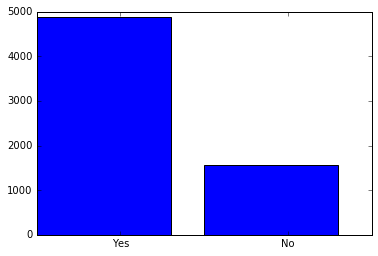

In [37]:
plt_bar()

In [56]:
len(tmp_df.sample(frac=0.1, replace=True))
len(tmp_df[tmp_df['answers_yn'] == 'No'].sample(frac=0.70, replace=True))

1095